---
# first in receipt prediction on multiple targets, fas data set 

In [1]:
import pandas as pd
import numpy as np
import matplotlib  
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import re
import os
from datetime import datetime
os.getcwd()

'c:\\Users\\dscshap3808\\Documents\\my_scripts_new\\play3_first_pre_time_series'

In [56]:
# import scipy

In [2]:

# path0 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2019 outbound\\'
# path1 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2020 outbound\\'
# # path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2021 outbound\\'
# path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\保乐力加_train\\outbound\\'
# %%time
# dfs0 = pd.DataFrame()
# for fname in os.listdir(path0):
#     if re.search(r'\.xls$', fname):
#         dfs0 = pd.concat(
#             [dfs0 ,pd.read_excel(path0 + fname)], 
#             axis = 0, 
#             ignore_index = True)

# dfs1 = pd.DataFrame()
# for fname in os.listdir(path1):
#     if re.search(r'\.xls$', fname):
#         dfs1 = pd.concat(
#             [dfs1 ,pd.read_excel(path1 + fname)], 
#             axis = 0, 
#             ignore_index = True)


# dfs2 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xls$', fname):
#         dfs2 = pd.concat(
#             [dfs2 ,pd.read_excel(path2 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# dfs2 = dfs2.dropna(axis =1 , how = 'all')
 
# # path+
# dfs = pd.DataFrame()
# for fname in os.listdir(path):
#     if re.search(r'\.xls$', fname):
#         dfs = pd.concat(
#             [dfs ,pd.read_excel(path + fname)], axis = 0, ignore_index = True)
# prc_in = pd.DataFrame(dfs)
# prc_in = prc_in.drop(['仓库城市','仓库编号','Unnamed: 7'], axis = 1)
# prc_in.columns = ['time', 'sku','name','code','quant']

# dfs3 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xlsx$', fname):
#         dfs3 = pd.concat(
#             [dfs3 ,pd.read_excel(path3 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
  
# # dfs2.head(200)

In [3]:
# df = pd.read_clipboard()
# df.to_csv('./fas_057_rh.csv', index = False, encoding='utf_8_sig')
df = pd.read_csv('./fas_057_rh.csv')
df = df.fillna(method = 'ffill')
df_test = pd.read_csv('./fas_inbhdr_test.csv')
df_test = df_test.fillna(method = 'ffill')
# df_test.columns = [re.sub(r'.+\.','',i) for i in df_test.columns]
df_test = df_test[df_test['RECEIPT_DATE'] > '2021-05-10']


In [4]:
df.columns = [i.upper() for i in df.columns.to_numpy()]
df_test.columns = [i.upper() for i in df_test.columns.to_numpy()]

def date_mutate(col, df):
    df[col + '_TIME'] = df[col].str.slice(11,-1).astype(str)
    df[col] = df[col].str.slice(0,10)
    df[col + '_2'] = [datetime.strptime(i,'%H:%M:%S.%f').strftime('%H%M%S') \
        for i in df[col + '_TIME']]
    return df.head(1)

for i in df.columns[df.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i, df)


first_df = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index();first_df


first_df = first_df.merge(
    df, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')



for i in df_test.columns[df_test.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i, df_test)

df_test_first = df_test.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index()


df_test_first = df_test_first.merge(
    df_test, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')

In [5]:
def data_mani(first_df, df):
    train_first = first_df.groupby(
        'CREATION_DATE_TIME_STAMP'
        ).agg({'RECEIPT_ID':['nunique'], 
        'TOTAL_LINES': ['sum'], 
        'TOTAL_CONTAINERS': 'sum', 
        'TOTAL_WEIGHT':'sum',
        'TOTAL_QTY': ['sum'],
        'CREATION_DATE_TIME_STAMP_2': 'min' }).reset_index()
        
    train_full = df.groupby(
        'CREATION_DATE_TIME_STAMP'
        ).agg({'RECEIPT_ID':['nunique'], 
        'TOTAL_LINES': ['sum'], 
        'TOTAL_CONTAINERS': 'sum', 
        'TOTAL_WEIGHT':'sum',
        'TOTAL_QTY': ['sum'],
        'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()

    train_full.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']
    train_first.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']

    train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], \
        yearfirst = True,  format='%Y-%m-%d')
    train_full.index = train_full['CREATION_DATE_TIME_STAMP']
    train_full.index = pd.DatetimeIndex(train_full.index)

    train_full['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_full['CREATION_DATE_TIME_STAMP'])
    train_first['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'])
    return train_first  , train_full 



In [6]:
train_first, train_full = data_mani(first_df, df)
test_first, test_full = data_mani(df_test_first, df_test)

<AxesSubplot:xlabel='container_sum', ylabel='qty'>

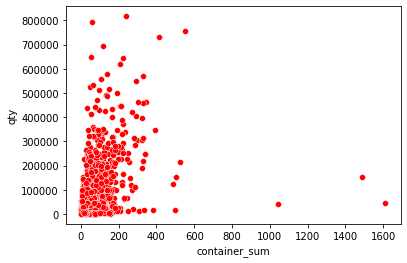

In [7]:
sns.scatterplot(x = 'container_sum', y  ='qty', color = 'red' , data = train_full)

<AxesSubplot:xlabel='qty', ylabel='Count'>

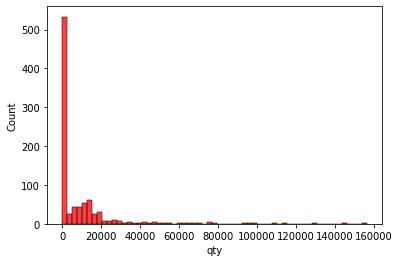

In [8]:
sns.histplot(train_first['qty'],color = 'red' )

<AxesSubplot:xlabel='qty', ylabel='Count'>

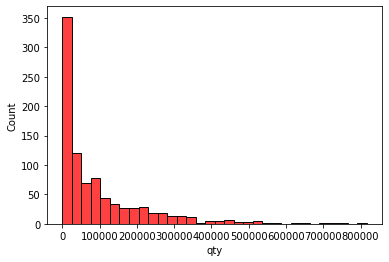

In [9]:
sns.histplot(train_full['qty'],color = 'red' )

---

## deal with outbound data

In [70]:
# ob_train = pd.read_csv('./outb_fas.csv', parse_dates=['date'])
# ob_train = ob_train.dropna(how = 'all', axis = 1)

--- 

In [ ]:
# train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], yearfirst = True,  format='%Y-%m-%d')
# train_first.pop('CREATION_DATE_TIME_STAMP')
# train_full.pop('CREATION_DATE_TIME_STAMP')
# train_full['qty'] = train_full['qty'].astype(int)
# train_first['qty'] = train_first['qty'].astype(int)
# train_first['qty2'] = train_full['qty'].to_numpy() ; train_first

# train_first = train_first.reset_index()
# train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) 

# sktime; timeseries only prediction on trainfull


In [71]:
# train_full.index = train_full['CREATION_DATE_TIME_STAMP']
# train_full.index = pd.DatetimeIndex(train_full.index);train_full.index
train_full_sktime = train_full.asfreq('D')
train_full_sktime = train_full_sktime.fillna(0);train_full_sktime


,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
CREATION_DATE_TIME_STAMP,,,,,,,
2017-09-11,2017-09-11 00:00:00,1.000,2.000,22.000,22000.000,880.000,032456
2017-09-12,2017-09-12 00:00:00,9.000,30.000,96.000,850242.840,512046.000,084029
2017-09-13,2017-09-13 00:00:00,6.000,9.000,41.000,41290.000,1778.000,014356
2017-09-14,2017-09-14 00:00:00,11.000,49.000,140.000,121620.000,16690.000,071055
2017-09-15,2017-09-15 00:00:00,4.000,16.000,36.000,96619.200,93797.000,034049
...,...,...,...,...,...,...,...
2021-05-03,0,0.000,0.000,0.000,0.000,0.000,0
2021-05-04,0,0.000,0.000,0.000,0.000,0.000,0
2021-05-05,0,0.000,0.000,0.000,0.000,0.000,0


In [72]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.regression import ComposableTimeSeriesForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_percentage_error

x = train_full_sktime.drop(['qty', 'CREATION_DATE_TIME_STAMP', 'creat_time'], axis = 1)
y = train_full_sktime.loc[:,'qty']
x_train, x_test , y_train, y_test = temporal_train_test_split(x, y)
#
#  # fh = ForecastingHorizon(x_test, is_relative=False)
# forecaster = ComposableTimeSeriesForestRegressor(x = x_train, y = y_train)
# forecaster.fit(x_train ,y = y_train)
# y_pred = forecaster.predict(x_test)
# mean_absolute_percentage_error(y_test, y_pred)

forecaster = NaiveForecaster(sp = 21)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh )
mean_absolute_percentage_error(y_test, y_pred)



C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning:

Timestamp.freqstr is deprecated and will be removed in a future version.

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\utils\datetime.py:88: FutureWarning:

Timestamp.freq is deprecated and will be removed in a future version

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\sktime\utils\datetime.p

5.912689654254918e+19

In [6]:
from sktime.regression.interval_based import  TimeSeriesForestRegressor

In [74]:
x_train.shape[1]

4

In [ ]:
# forecaster = TimeSeriesForestRegressor( )
# # fh = ForecastingHorizon(x_test, is_relative=False)
# forecaster.fit(X = x_train,  y = y_train)
# y_pred = forecaster.predict(x_test)
# mean_absolute_percentage_error(y_test, y_pred)

---

# prophet prepare

In [11]:
# train_full = train_full_sktime
train_full = train_full.asfreq('D')
train_full = train_full.fillna(0) 
train_first = train_first.asfreq('D')
train_first = train_first.fillna(0)
train_full['CREATION_DATE_TIME_STAMP'] = train_full.index
train_first['CREATION_DATE_TIME_STAMP'] = train_first.index


# train_full
train_full = train_full.reset_index(drop =True)
train_first = train_first.reset_index(drop =True)

train_fin = train_full.merge(train_first, 
    on = 'CREATION_DATE_TIME_STAMP', 
    how = 'outer',
    suffixes = ['_full', '_first'])
train_fin = train_fin.fillna(0);train_fin

,CREATION_DATE_TIME_STAMP,id_full,line_sum_full,container_sum_full,weight_full,qty_full,creat_time_full,id_first,line_sum_first,container_sum_first,weight_first,qty_first,creat_time_first
0,2017-09-11,1.0,2.0,22.0,22000.00,880.0,032456,1.0,2.0,22.0,22000.0,880.0,032456
1,2017-09-12,9.0,30.0,96.0,850242.84,512046.0,084029,1.0,1.0,19.0,18600.0,744.0,050737
2,2017-09-13,6.0,9.0,41.0,41290.00,1778.0,014356,1.0,1.0,1.0,100.0,4.0,012211
3,2017-09-14,11.0,49.0,140.0,121620.00,16690.0,071055,1.0,1.0,9.0,8000.0,6000.0,002402
4,2017-09-15,4.0,16.0,36.0,96619.20,93797.0,034049,1.0,2.0,13.0,12525.0,501.0,014709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2021-05-03,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
1331,2021-05-04,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
1332,2021-05-05,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
1333,2021-05-06,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
# train_full = train_full_sktime
test_full  = test_full.asfreq('D')
test_full  = test_full.fillna(0) 
test_first = test_first.asfreq('D')
test_first = test_first.fillna(0)
test_full['CREATION_DATE_TIME_STAMP']  = test_full.index
test_first['CREATION_DATE_TIME_STAMP'] = test_first.index


# train_full
test_full  = test_full.reset_index(drop =True)
test_first = test_first.reset_index(drop =True)

test_fin = test_full.merge(test_first, 
    on    = 'CREATION_DATE_TIME_STAMP', 
    how   = 'outer',
    suffixes = ['_full', '_first'])

test_fin = test_fin.fillna(0);test_fin

,CREATION_DATE_TIME_STAMP,id_full,line_sum_full,container_sum_full,weight_full,qty_full,creat_time_full,id_first,line_sum_first,container_sum_first,weight_first,qty_first,creat_time_first
0,2021-05-10,1.0,1.0,2.0,16196.60,12072.0,080914,1.0,1.0,2.0,16196.60,12072.0,080914
1,2021-05-11,4.0,13.0,35.0,66215.82,51258.0,090427,1.0,2.0,2.0,22075.20,17280.0,025243
2,2021-05-12,11.0,20.0,135.0,172374.90,232776.0,080112,1.0,1.0,12.0,16655.10,13860.0,012919
3,2021-05-13,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.00,0.0,0
4,2021-05-14,2.0,11.0,34.0,16479.23,12065.0,081753,1.0,8.0,29.0,15979.23,12060.0,081235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2021-08-20,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.00,0.0,0
103,2021-08-21,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.00,0.0,0
104,2021-08-22,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.00,0.0,0
105,2021-08-23,11.0,12.0,0.0,2629700.40,209580.0,033211,1.0,1.0,0.0,199861.20,13860.0,032128


In [13]:
def span_mani(train_fin, train_first): 
    # train_full['creat_time_first'] = ''
    train_fin['span_first'] = train_fin[
        'creat_time_first'
        ].str.slice(1,2).fillna(
            0
            ).astype(int, errors = 'ignore') + train_fin['creat_time_first'].str.slice(2,4).fillna(
                0
                ).astype(int, errors = 'ignore')/60*1 + 8

    # # train_full['creat_time_x']
    # train_first['span_full'] = train_first['creat_time_full'].str.slice(1,2).astype(int) + 
    #     train_first['creat_time_full'].str.slice(2,4).astype(int)/60*1 + 8
    train_first['span_first'] = train_first[
        'creat_time'
        ].str.slice(1,2).fillna(
            0
            ).astype(int, errors = 'ignore') + train_first['creat_time'].str.slice(2,4).fillna(
                0
                ).astype(int, errors = 'ignore')/60*1 + 8
    train_first = train_first.drop('creat_time', axis = 1)
    return train_fin, train_first

In [14]:
train_fin, train_first = span_mani(train_fin, train_first)
test_fin, test_first   = span_mani(test_fin, test_first) 

In [15]:
# modeles

In [16]:
# from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split

x = train_first 
x['y'] = train_fin['qty_full']
# x['CREATION_DATE_TIME_STAMP'] = x.index
x_train, x_test = train_test_split(x, train_size = .75, shuffle = False, random_state = 52943)

cols = [i for i in x.columns if i not in ['y', 'CREATION_DATE_TIME_STAMP']]


In [13]:
%%time

from fbprophet import Prophet
# df = x[['CREATION_DATE_TIME_STAMP', 'qty']]
df_naiv = x_train 
df_naiv = df_naiv.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols]

m.fit(df_naiv)

from sklearn.metrics import mean_absolute_percentage_error
df_naiv_test = x_test
df_naiv_test = df_naiv_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
# m.predict(x_test)
mean_absolute_percentage_error(df_naiv_test['y'], m.predict(df_naiv_test)['yhat'])
# fig = m.plot_components(m.predict(x_test))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 7.32 s


3.878807837446074e+19

In [ ]:
# m.plot_components(m.predict(df2))
# plt.show()

In [ ]:
# m.plot(m.predict(df2))
# plt.show()

---

# pseudo labeling

In [17]:
def labeling_mani(train_first, train_full):
    train_first['dif'] = train_first['qty'] - train_full['qty'] != 0
    train_first['dif'] = [1 if i == True else 0 for i in train_first['dif']]

    train_full['dif'] = train_first['qty'] - train_full['qty'] != 0
    train_full['dif'] = [1 if i == True else 0 for i in train_full['dif']]
    return train_first , train_full
# train_full['diff'] = train_full['qty_x'] - train_full['qty_y'] ==  0
# train_full['diff'] = [1 if i == True else 0 for i in train_full['diff']]
# train_full = train_full.asfreq('D')

In [18]:
labeling_mani(train_first, train_full)
test_first, test_full = labeling_mani(test_first, test_full)

In [19]:
x = train_first.drop('y', axis  =1 )
x_train, x_test = train_test_split(x, train_size = .75, shuffle = False, random_state = -1)


In [20]:
%%time
from fbprophet import Prophet 
df_lb = x_train 

## qty_x s是最终预测值, 所以要drop
cols_lb = [i for i in df_lb.columns 
    if i not in ['dif', 'CREATION_DATE_TIME_STAMP']]

# df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
m = Prophet(daily_seasonality=True) 

"""
0.12379144878303337 daily_seasonality=True; empty 0.12318682390845224
"""


[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)

# ?mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score

# x_test1 = x_test.drop(['dif'], axis =1 )
x_test1 = x_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
 
# m.predict(x_test)
forecast = m.predict(x_test1)
mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
# fig = m.plot_components(m.predict(x_test))

Wall time: 17.1 s


0.12379144878303337

In [27]:
# # %%warning = False
# from prophet.plot import plot_plotly, plot_components_plotly
# plot_plotly(m, forecast)
 

In [24]:
lb_prophet_result = pd.DataFrame(forecast['yhat'])
lb_prophet_result['abs_diff'] = np.abs(forecast['yhat'] - .5)
lb_prophet_result.sort_values('abs_diff').iloc[0,0]

0.7434468844249535

In [25]:
acc_score_data  = [1 if i>=lb_prophet_result['yhat'].mean() \
    else 0 for i in forecast['yhat']]

acc_score_data1 = [1 if i>=lb_prophet_result.sort_values('abs_diff').iloc[0,0] \
    else 0 for i in forecast['yhat']]
    
acc_score_data2 = [1 if i>lb_prophet_result['yhat'].std() \
    else 0 for i in forecast['yhat']]

# mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
[accuracy_score(x_test1['y'],i) for i in [acc_score_data, acc_score_data1, acc_score_data2]]


[0.9161676646706587, 0.9161676646706587, 0.9161676646706587]

### pred 2 the id number predicting:

In [28]:
# pred 2 the id number predicting:
id_cnt_train = train_first.copy()
id_cnt_train = id_cnt_train[id_cnt_train['dif'] != 0]
id_cnt_train['y'] = train_full['id']
"""
[4.806768544455207, 1.1680515078598923]
[7.133413104312447, 0.6253522370101863]  # id
"""
# id_cnt_train['y'] = train_full['line_sum']

"""
[16.60773539220494, 0.6975939132491072] # line_sum
"""
id_cnt_train

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,span_first,y,dif
1,2017-09-12,1.0,1.0,19.0,18600.00,744.0,13.116667,9.0,1
2,2017-09-13,1.0,1.0,1.0,100.00,4.0,9.366667,6.0,1
3,2017-09-14,1.0,1.0,9.0,8000.00,6000.0,8.400000,11.0,1
4,2017-09-15,1.0,2.0,13.0,12525.00,501.0,9.783333,4.0,1
7,2017-09-18,1.0,1.0,1.0,0.00,600.0,8.966667,16.0,1
...,...,...,...,...,...,...,...,...,...
1309,2021-04-12,1.0,3.0,25.0,16244.00,9600.0,16.166667,11.0,1
1310,2021-04-13,1.0,1.0,1.0,17186.40,16632.0,8.766667,13.0,1
1313,2021-04-16,1.0,2.0,14.0,7963.50,4680.0,11.766667,12.0,1
1322,2021-04-25,1.0,3.0,18.0,18486.72,24192.0,15.983333,6.0,1


In [30]:
# x = id_cnt_train.drop('y', axis  =1 )
x_train, x_test = train_test_split(id_cnt_train,\
     train_size = .75, shuffle = False, random_state = None)

## qty_x s是最终预测值, 所以要drop
cols_lb = [i for i in x_train.columns 
    if i not in ['y', 'CREATION_DATE_TIME_STAMP']]

x_train = x_train.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
m2 = Prophet(daily_seasonality=True) 

[m2.add_regressor(i) for i in cols_lb]

m2.fit(x_train)

In [31]:

# x_test1 = x_test.drop(['dif'], axis =1 )
x_test1 = x_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
 
# m.predict(x_test)
forecast_2 = m2.predict(x_test1)
[mean_absolute_error(x_test1['y'], forecast_2['yhat']),\
     mean_absolute_percentage_error(x_test1['y'], forecast_2['yhat'])]

[7.133413104312447, 0.6253522370101863]

# test data validate

In [32]:
train_all = x
train_all = train_all.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
# m2 = Prophet(daily_seasonality=True) 
# m2.fit(train_all)

In [33]:
# a
test_all  = test_first.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
test_pred = m.predict(test_all)
 
mean_absolute_error(test_all['y'], test_pred['yhat'])

0.11115463834678584

In [34]:
acc_tst = [1 if i>=test_pred['yhat'].mean() \
    else 0 for i in test_pred['yhat']]
accuracy_score(acc_tst, test_all['y'])

0.9345794392523364

In [35]:
import nbformat
nbformat.__version__

'5.1.3'

In [36]:
import plotly.express as px

In [37]:
# %%warning = False
test_pre_p = go.Figure()
test_pre_p.add_trace(go.Scatter(x = test_pred['ds'],\
    y = test_pred['yhat'], 
    mode = 'markers',
    name = 'pred'))
test_pre_p.add_trace(go.Scatter(x = test_all['ds'], \
    y = test_all['y'], 
    mode = 'markers',
    name = 'original_out'))


In [53]:
# # %%warning = False
# test_pre_p = go.Figure()
# test_pre_p.add_trace(go.Scatter(x = test_all['ds'], \
#     y = test_all['y'], 
#     mode = 'markers',
#     name = 'original_out'))
# test_pre_p.add_trace(go.Scatter(x = test_pred['ds'],\
#     y = test_pred['yhat'], 
#     mode = 'markers',
#     name = 'pred'))
# test_pre_p.show() 

----
## try h2o predict qty

In [ ]:
x_train2 = x_train[x_train['dif'] == 1] 
x_test2 = x_test[x_test['dif'] == 1];len(x_test2)
x_train2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[0:len(x_train2), :]['qty']
x_test2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[len(x_train2):, :]['qty'];x_train2

In [ ]:
import h2o
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator
h2o.init()


In [ ]:
cols_h2o = [i for i in x_train2.columns.to_numpy() if i not in 'qty_tar']

# Import the prostate dataset
h2o_df = h2o.H2OFrame(x_train2)
# Split the data giving the training dataset 75% of the data
train,test = h2o_df.split_frame(ratios=[0.75])

# Build an Isolation forest model
model = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 500)
model.train(training_frame=train,x =cols_h2o)

# Calculate score
score = model.predict(test)
result_pred = score["predict"]

# Predict the leaf node assignment
ln_pred = model.predict_leaf_node_assignment(test, "Path")

In [ ]:
score_train = model.predict(train)
forest_pred_trai = pd.concat([score_train['predict'].as_data_frame(),\
    result_pred.as_data_frame() ], axis = 0).reset_index()
forest_pred_test = model.predict(h2o.H2OFrame(x_test2))

In [ ]:
train.as_data_frame()
train.as_data_frame().append(score_train.as_data_frame())

In [ ]:
score2

In [ ]:
# Generate predictions on a test set (if necessary):
pred = dl.predict(test)

In [ ]:
sult = pd.concat([test.as_data_frame()['qty_tar'], pred.as_data_frame()], axis = 1)

In [ ]:
sult

In [ ]:
mean_absolute_percentage_error(sult['qty_tar'], sult['predict'])

In [ ]:
x_train2 = x_train2.reset_index()
x_test2 = x_test2.reset_index()
x_train2['labels'] = forest_pred_trai['predict'] 
x_test2['labels'] = forest_pred_test.as_data_frame()['predict']

In [ ]:
predictors = [i for i in x_train2.columns.to_numpy() if i not in 'qty_tar']
response = 'qty_tar'
# Import the prostate dataset
h2o_df = h2o.H2OFrame(x_train2)
# Split the data giving the training dataset 75% of the data
train,test = h2o_df.split_frame(ratios=[0.75])

dl = H2ODeepLearningEstimator(distribution="AUTO",
                               hidden=[300,300],
                               epochs=600,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               activation="Rectifierwithdropout",
                               single_node_mode=False,
                               balance_classes=False,
                               force_load_balance=False,
                               seed=707,
                               tweedie_power=1.5,
                               score_training_samples=0,
                               score_validation_samples=0,
                               score_each_iteration = True,
                               stopping_rounds=0)
dl.train(x=predictors,
         y=response,
          training_frame= train,
          validation_frame = test)

# Eval performance:
perf = dl.model_performance();perf


In [ ]:
perf

In [ ]:
test_lb_qty_test2 = dl.predict(test).as_data_frame()

In [ ]:
test_lb_qty_test2

In [ ]:
mean_absolute_percentage_error(sult['qty_tar'], sult['predict'])

----
## Darts

In [38]:
df_lb , x_test1 

"""
the dataframes are taken from fbprophet model, 
no need to split anyway.
"""

'\nthe dataframes are taken from fbprophet model, \nno need to split anyway.\n'

In [41]:
from darts import TimeSeries

AttributeError: module 'xarray' has no attribute 'DataArray'

In [40]:
from darts import TimeSeries

series_train = TimeSeries.from_dataframe(df_lb, 
       time_col = 'ds', 
       value_cols ='y')
series_test = TimeSeries.from_dataframe(x_test1, 
       time_col = 'ds', 
       value_cols =  'y')
series_train_cov = TimeSeries.from_dataframe(df_lb,\
       'ds',
       ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'])
series_test_cov = TimeSeries.from_dataframe(x_test1, 
       'ds', 
       ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'] )

AttributeError: module 'xarray' has no attribute 'DataArray'

In [ ]:
ful_span = TimeSeries.from_dataframe(df_lb.append(x_test1), \
    'ds', 
    value_cols = 'y')
ful_span_cov = TimeSeries.from_dataframe(df_lb.append(x_test1), \
    'ds', 
    ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'] )

In [5]:
from darts.models import RNNModel
md1_bert = NBEATSModel(input_chunk_length=31, \
    output_chunk_length=15, n_epochs=5, random_state=43)
    
# md2_lstm = BlockRNNModel(model='LSTM', \
#     input_chunk_length=12, output_chunk_length=6, n_epochs=5, random_state=43)


NameError: name '_C' is not defined

 > ## *Past Covariates denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed. * Future Covariates denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts.*
> 
> 
 > ## input_chunk_length: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous input_chunk_length points. 

In [ ]:
%%time
md1_bert.fit(series = series_train, \
    past_covariates = series_train_cov,
    verbose=True)

In [ ]:
%%time
backtest_bert = md1_bert.historical_forecasts(series_train,\
    past_covariates = series_train_cov,
    start = .75,
    retrain = False)

# backtest_cov = model_cov.historical_forecasts(series_air_scaled,
#                                               past_covariates=air_covariates,
#                                               start=0.6,
#                                               forecast_horizon=12,
#                                               stride=1,
#                                               retrain=False,
#                                               verbose=True)


In [ ]:
backtest_bert.values()

In [ ]:
%%time
train_pred_bert = md1_bert.predict(n = 334 , 
    past_covariates = series_train_cov,
    # future_covariates = series_test_cov
    )
train_pred_bert.values()

In [ ]:
from darts.metrics import mape
mean_absolute_error(train_pred_bert.values(), series_test.values())

## lSTM in darts

In [42]:
%%time
LSTM_darts = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=7,
    n_epochs=5,
    optimizer_kwargs={'lr': 1e-3},
    model_name='lstm_RNN',
    log_tensorboard=True,
    random_state=42,
    # training_length=20,
    input_chunk_length=31,
    force_reset=True
)
LSTM_darts.fit(series_train,
             future_covariates=series_train_cov,
            #  val_series=series_test,
            #  val_future_covariates=series_test_cov,
             verbose=True)

NameError: name 'RNNModel' is not defined

In [ ]:
np.set_printoptions(suppress=True)
lstm_pred_test = LSTM_darts.predict(n = 334, future_covariates = ful_span_cov).values()

In [ ]:
acc_score_data  = [1 if i>=lstm_pred_test.mean() \
    else 0 for i in lstm_pred_test]

# acc_score_data1 = [1 if i>=lstm_pred_test.sort_values() \
#     else 0 for i in forecast['yhat']]
    
# acc_score_data2 = [1 if i>lb_prophet_result['yhat'].std() \
#     else 0 for i in forecast['yhat']]

# mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
# [accuracy_score(x_test1['y'],i) for i in [acc_score_data, acc_score_data1, acc_score_data2]]
accuracy_score(x_test1['y'],acc_score_data) 

In [ ]:
lstm_plt = x_test1.copy()
lstm_plt['y_pred'] = lstm_pred_test

In [ ]:
import plotly.express as ex
fig = ex.scatter(data_frame=lstm_plt, x = 'ds', y = 'y')
fig.add_scatter(x = lstm_plt['ds'],  y = lstm_plt['y_pred'])
fig.show()

In [ ]:
# import altair as alt
# brush = alt.selection_interval()
# alt.Chart(lstm_plt).mark_point().encode(
#     x='ds',
#     y='y'
# ).add_selection(
#     brush
# )
 

In [ ]:
# min(abs(lstm_plt['y_pred'] - .5))

lstm_plt['abs_diff'] = np.abs(lstm_plt['y_pred'] - .5)
lstm_plt.sort_values('abs_diff')

In [ ]:
pred_1_lable1 = [1 if i> 0.565032 else 0 for i in lstm_plt['y_pred']]
# lstm_plt['y_pred']
pred_1_lable2 = [1 if i> lstm_plt['y_pred'].mean() else 0 for i in lstm_plt['y_pred']]

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
[accuracy_score(lstm_plt['y'], pred_1_lable1),
accuracy_score(lstm_plt['y'], pred_1_lable2)]

In [ ]:


# series.plot(label='data')
# for i, m in enumerate(berkets):
#     err = mape(backtests[i], series)
#     backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

# plt.title('Backtests with 3-months forecast horizon')
# plt.legend()

---

## qty prediction, filter data which not 1

In [ ]:
x_train2 = x_train[x_train['dif'] == 1] 
x_test2 = x_test[x_test['dif'] == 1];len(x_test2)
x_train2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[0:len(x_train2), :]['qty']
x_test2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[len(x_train2):, :]['qty']

In [ ]:
[len(x_train2),len(x_test2)]

In [ ]:
df_2_all = pd.DataFrame(pd.concat([x_train2, x_test2], axis = 0)).reset_index(); df_2_all

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

tran3 = ColumnTransformer([
        ('somename', StandardScaler(), ['weight', 'qty', 'qty_tar'])
    ])
tran3.fit(df_2_all[['weight', 'qty', 'qty_tar']])

df_2_all[['weight', 'qty',  'qty_tar']] = pd.DataFrame(
    tran3.fit_transform(df_2_all[['weight', 'qty', 'qty_tar']])

) 

In [ ]:
# tran2.fit(x_train2[['weight', 'qty', 'span_first']])
# tran2.transform(x_test2[['weight', 'qty', 'span_first']])

df_2_all =df_2_all.fillna(0)
x_train2 = df_2_all.iloc[0:652,:]
x_test2 = df_2_all.iloc[652:,:]

In [ ]:
from fbprophet import Prophet 
df_lb = x_train2

## qty_x s是最终预测值, 所以要drop
cols_lb = [i for i in df_lb.columns 
    if i not in ['qty_tar', 'CREATION_DATE_TIME_STAMP']]

# df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_tar': 'y'}, axis = 1)
m = Prophet(daily_seasonality=True)
[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)


# ?mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score

# x_test1 = x_test.drop(['dif'], axis =1 )
x_test1 = x_test2.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_tar': 'y'}, axis = 1)
 
# m.predict(x_test)
forecast = m.predict(x_test1)
mean_absolute_percentage_error(x_test1['y'], m.predict(x_test1)['yhat'])
# fig = m.plot_components(m.predict(x_test))

---
# cross validation on prophet

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, initial='365 days', period='31 days', horizon = '180 days')


In [ ]:
df_cv = pd.DataFrame(df_cv);df_cv

In [ ]:
sns.scatterplot(data = df_cv, x = 'ds', y = 'yhat')

In [ ]:
performance_metrics(df_cv).sort_values('mae')

## Tunning paras

In [ ]:
from fbprophet import Prophet 
df_lb = x_train 
cols_lb = [i for i in df_lb.columns 
    if i not in ['diff','qty_x','creat_time_x','creat_time_y','CREATION_DATE_TIME_STAMP']]

df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'diff': 'y'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)

In [ ]:
%%Time
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.01,  0.5],
    'seasonality_prior_scale': [0.01, 0.1],
}
 

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    [m.add_regressor(i) for i in cols_lb]
    m.fit(df_lb)
    df_cv = cross_validation(m, 
        initial='365 days', period='31 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
df_lb

In [ ]:
x_test1 = x_test.drop(['creat_time_x','creat_time_y', 'qty_x', 'diff'], axis =1 )
x_test1 = x_test1.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
x_test1['y'] = 0
m.predict(x_test1)
mean_absolute_error(x_test['diff'], m.predict(x_test1)['yhat'])

In [ ]:
values = m.predict(x_test1)['yhat']
labels = [1 if i>.5 else 0 for i in values]

In [ ]:
x_test['pred_labels'] = labels;x_test


In [ ]:
accuracy_score(x_test['diff'], x_test['pred_labels'])

In [ ]:
x_train

In [ ]:
# qty_x is target
from fbprophet import Prophet 
df_value = x_train 
df_value = df_value.drop(['creat_time_x','creat_time_y'], axis =1 )

df_value = df_value.rename({
    'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_x': 'y', 'diff':'pred_labels'
    }, axis = 1)

    
cols_value = [i for i in df_value.columns 
    if i not in ['y', 'ds', 'pred_labels']]

m = Prophet()
[m.add_regressor(i) for i in cols_value]

m.fit(df_value)

In [ ]:
df_value

In [ ]:
x_test_fin = x_test.drop(['creat_time_x','creat_time_y', 'qty_x', 'diff'], axis =1 )
 
x_test_fin = x_test_fin.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1);
x_test_fin

In [ ]:

# m.predict(x_test_fin)
mean_absolute_percentage_error(x_test['qty_x'], m.predict(x_test_fin)['yhat'])

# aaa

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(
    n_splits = 6, 
    test_size = .25, 
    # max_train_size = .75
    )
alg1 = Lasso()

cv_results_1 = model_selection.cross_validate(
    alg1, 
    train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) , train_first['qty2'].to_numpy(), 
    cv  = cv_split, scoring='neg_mean_absolute_percentage_error')


cv_results_1['test_score'].mean()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
alg2 = RandomForestRegressor(n_estimators = 34, 
        max_depth = 61,
        min_samples_split = 3, 
        min_samples_leaf=4, 
        # max_leaf_nodes = 31
        )
cv_results_2 = model_selection.cross_validate(
        alg2, 
        train_first, 
        train_full['qty'], 
        cv  = cv_split, scoring='neg_mean_absolute_percentage_error')
cv_results_2['test_score'].mean()

In [ ]:
alg2.fit(train_first,train_full['qty']).predict(train_first)

In [ ]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (891, 891, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'identity', 
    solver = 'adam', learning_rate = 'adaptive')
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

In [ ]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (1120, 850, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'relu', 
    solver = 'adam', 
    learning_rate = 'adaptive',
    warm_start = True,
    early_stopping = True
    )
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()